In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from helpers import lorenz, rossler, rk4
from scipy.fft import fft, ifft, fftshift, fftfreq

In [8]:
'''
Generate and save target functions
'''

save_dir = '/home/spate/Res/targets/'
n_samples = 500
n_steps = 4000
dt = 0.01
var_names = ["x", "y", "z"]
fcn_name = "lorenz"
d = 3 # Dimension of system
do_save = True
do_plot = False

if fcn_name == "lorenz":
    fcn = lorenz
    params = {'sig':10, 'rho':28, 'beta':8/3}
elif fcn_name == "rossler":
    fcn = rossler
    params = {'a':0.2, 'b':0.2, 'c':5.7}

t = np.linspace(0, n_steps * dt, num=n_steps)

sol_stack = []
for j in range(n_samples):
    y0 = np.random.uniform(size=(d,)) - 0.5

    sol = []
    y_prev = y0
    for i in range(n_steps):
        sol.append(y_prev)
        y = rk4(fcn, y_prev, dt, params)
        y_prev = y

    sol = np.stack(sol, axis=1)
    sol_stack.append(sol)

    if do_plot:
        fig, ax = plt.subplots(1, 2, figsize=(16,8))
        ax[0].plot(sol[1], sol[2])
        ax[1].plot(sol[0], sol[1])


        ax[0].set_ylabel("z")
        ax[0].set_xlabel("y")
        ax[1].set_ylabel("y")
        ax[1].set_xlabel("x")

        fig.tight_layout()
        plt.show()


        fig, ax = plt.subplots(3, 1, figsize=(16,8), sharex=True)
        for i in range(sol.shape[0]):
            ax[i].plot(t, sol[i])
            ax[i].set_xlabel("t")
            ax[i].set_ylabel(var_names[i])
            
        fig.tight_layout()
        plt.show()

sol_stack = np.concatenate(sol_stack, axis=0)

params_str = ''
for k,v in params.items():
    params_str += k + f"_{v:.2f}_"

if do_save:
    np.savetxt(save_dir + f"{fcn_name}_params_{params_str}n_samples_{n_samples}_n_steps_{n_steps}_dt_{dt}.csv", sol_stack, delimiter=",")



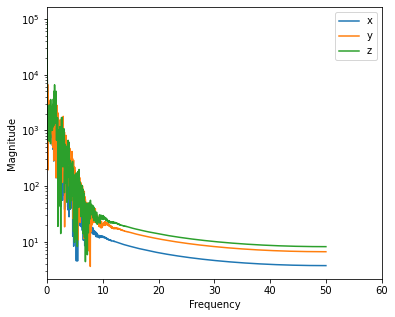

In [18]:
'''
Fourier analysis of lorenz
'''
save_dir = '/home/spate/Res/figures/'
n_samples = 500
d = 3
n_steps = 4000
dt = 0.01
var_names = ["x", "y", "z"]
target_fn = '/home/spate/Res/targets/lorenz_params_sig_10.00_rho_28.00_beta_2.67_n_samples_500_n_steps_4000_dt_0.01.csv'
target_batch = np.loadtxt(target_fn, delimiter=',').reshape(n_samples, d, n_steps)
# f = np.sin(20* 2 * np.pi * t)


fig, ax = plt.subplots(figsize=(6,5))

for i in range(d):
    f = target_batch[0,i,:].reshape(-1,) # [n_samples, d, n_steps]
    f_hat = fftshift(fft(f))
    freqs = fftshift(fftfreq(n_steps, dt))

    ax.plot(freqs, np.abs(f_hat), label=var_names[i]) # Plot

ax.set_yscale('log')
ax.set_xlim(0,60)
ax.set_ylabel("Magnitude")
ax.set_xlabel("Frequency")
ax.legend()
plt.savefig(save_dir + "lorenz_fourier.png")
plt.show()

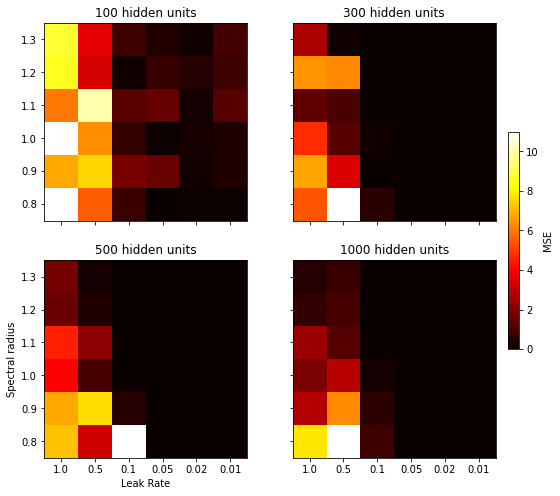

In [19]:
'''
Grid search
'''
save_dir = '/home/spate/Res/figures/'
n_repeats = 10
leak_rates = np.array([1, 0.5, 0.1, 0.05, 0.02, 0.01])
spectral_radii = np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
n_params = np.arange(6)
n_hiddens = np.array([100, 300, 500, 1000])
mse_min = 0
mse_max = 11


fig, ax = plt.subplots(2, 2, figsize=(9,8), sharey=True, sharex=True, gridspec_kw={"width_ratios":[4/5, 1]})

for i, n in enumerate(n_hiddens):

    # Load data
    fn = f"lorenz_grid_search_spectral_radius_leak_rate_hidden_units_{n}.csv"
    mse = np.loadtxt(fn, delimiter=',').reshape(spectral_radii.shape[0], leak_rates.shape[0], n_repeats)
    mse = mse.mean(axis=-1)
    # print(mse.min(), mse.max())

    ax[i // 2, i % 2].pcolormesh(n_params, n_params, mse, cmap='hot') # Plot

    # Label plot
    ax[i // 2, i % 2].set_title(f"{n} hidden units")
    ax[-1, 0].set_ylabel("Spectral radius")
    ax[-1, 0].set_xlabel("Leak Rate")
    ax[-1, -1].set_xticks(n_params)
    ax[-1, -1].set_yticks(n_params)
    ax[-1, -1].set_xticklabels(leak_rates)
    ax[-1, -1].set_yticklabels(spectral_radii)

cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=mse_min, vmax=mse_max)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='MSE', ax=ax[:,-1], shrink=0.5)
plt.savefig(save_dir + "grid_search_heatmap.png")
plt.show()

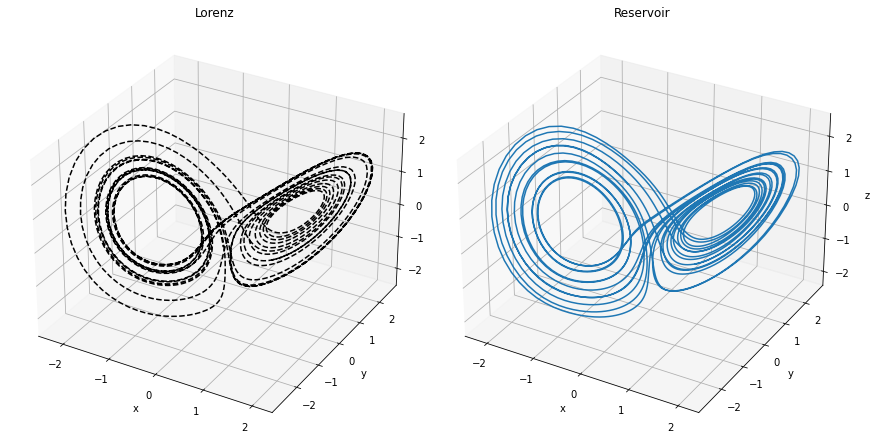

In [22]:
test_sample = 497
dt = 0.01 # For simulation of target system
end_forcing = 2000
save_dir = '/home/spate/Res/figures/'
fn_output = f"lorenz_prediction_outputs_test_sample_{test_sample}.csv"
fn_target = f"lorenz_prediction_target_test_sample_{test_sample}.csv"
lorenz_fn = '/home/spate/Res/targets/lorenz_params_sig_10.00_rho_28.00_beta_2.67_n_samples_500_n_steps_4000_dt_0.01.csv'
total_steps = 4000
d = 3
total_samples = 500
n_outputs = 3
do_scl = False

lorenz_lib = np.loadtxt(lorenz_fn, delimiter=',').reshape(total_samples, d, total_steps)
flat_lorenz = np.transpose(lorenz_lib, axes=[1, 0, 2]).reshape(n_outputs, -1)
lorenz_mean, lorenz_std = np.mean(flat_lorenz, axis=1).reshape(3,1), np.std(flat_lorenz, axis=1).reshape(3,1)

target = np.loadtxt(save_dir + fn_target, delimiter=',')[:, end_forcing:]
output = np.loadtxt(save_dir + fn_output, delimiter=',')[:, end_forcing:]

if do_scl:
    target = (target * lorenz_std) + lorenz_mean
    output = (output * lorenz_std) + lorenz_mean

fig = plt.figure(figsize=(12,9))

ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d")


ax0.plot(target[0,:], target[1,:], target[2,:], 'k--')
ax1.plot(output[0,:], output[1,:], output[2,:])

ax0.set_title("Lorenz")
ax1.set_title("Reservoir")
ax0.set_xlabel("x")
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax1.set_xlabel("x")
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# ax.view_init(azim=90, elev=10)
fig.tight_layout()
plt.savefig(save_dir + "lorenz_attractor_v_reservoir.png")
plt.show()